In [1]:
import os
os.getcwd()

'/home/onyxia/work/hackathon-un-2022/notebooks'

In [2]:
os.chdir("..")
import utils.functions as fc

In [3]:
from importlib import reload
fc = reload(fc)

In [4]:
ship_data_enriched = fc.create_ship_data_enriched()

In [5]:
path_parquet = "AIS/ais_ports_20190001_20190008.parquet"

ais_df = fc.read_ais_parquet(path_parquet=path_parquet)

In [6]:
ais_df.shape

(1014756, 26)

In [7]:
import pandas as pd

pd.options.display.max_columns = 30
ais_df.head()

,width,dt_static_utc,vessel_type_cargo,length,nav_status,dt_pos_utc,heading,cog,rot,dt_insert_utc,vessel_type_main,sog,draught,latitude,polygon_name,vessel_type,vessel_name,vessel_type_sub,H3_int_index_9,hex_resolution,longitude,mmsi,flag_country,destination,vessel_class,imo
0,47.0,2019-04-01 09:34:20,None,71.0,Not Defined,2019-04-01 10:00:59,0.0,0.0,0.0,2019-04-01 10:00:59,Offshore Vessel,0.0,0.0,45.561487,Chornomors Ke Buffer,Unknown,MODU SIVASH,None,617787929049432063,9,32.774457,273374830,Russian Federation,None,A,8763385.0
1,12.0,2019-04-01 11:50:19,None,55.0,Under Way Using Engine,2019-04-01 11:53:15,0.0,0.0,0.0,2019-04-01 11:53:15,Offshore Vessel,0.0,3.5,45.547278,Chornomors Ke Buffer,Tug,INYA,Offshore Tug Supply Ship,617787929086394367,9,32.796582,273370570,Russian Federation,YEVPATORIYA,A,8423258.0
2,12.0,2019-04-01 02:44:18,None,55.0,Under Way Using Engine,2019-04-01 02:51:42,0.0,0.0,0.0,2019-04-01 02:51:42,Offshore Vessel,0.0,3.5,45.552342,Chornomors Ke Buffer,Tug,INYA,Offshore Tug Supply Ship,617787929047334911,9,32.796950,273370570,Russian Federation,YEVPATORIYA,A,8423258.0
3,12.0,2019-04-01 22:26:17,None,55.0,Under Way Using Engine,2019-04-01 22:34:34,0.0,0.0,0.0,2019-04-01 22:34:34,Offshore Vessel,0.0,3.5,45.547288,Chornomors Ke Buffer,Tug,INYA,Offshore Tug Supply Ship,617787929086394367,9,32.796587,273370570,Russian Federation,YEVPATORIYA,A,8423258.0
4,12.0,2019-04-01 04:56:20,None,55.0,Under Way Using Engine,2019-04-01 05:01:27,0.0,0.0,0.0,2019-04-01 05:01:27,Offshore Vessel,0.0,3.5,45.552343,Chornomors Ke Buffer,Tug,INYA,Offshore Tug Supply Ship,617787929047334911,9,32.796925,273370570,Russian Federation,YEVPATORIYA,A,8423258.0


In [8]:
ais_df.columns

Index(['width', 'dt_static_utc', 'vessel_type_cargo', 'length', 'nav_status',
       'dt_pos_utc', 'heading', 'cog', 'rot', 'dt_insert_utc',
       'vessel_type_main', 'sog', 'draught', 'latitude', 'polygon_name',
       'vessel_type', 'vessel_name', 'vessel_type_sub', 'H3_int_index_9',
       'hex_resolution', 'longitude', 'mmsi', 'flag_country', 'destination',
       'vessel_class', 'imo'],
      dtype='object')

In [9]:
!pip install geopandas==0.12.1;
!pip install rtree;
!pip install pyarrow==10.0.0 s3fs folium

In [10]:
pip install rtree

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import rtree
import geopandas as gpd
from shapely.geometry import Point, mapping, Polygon
import re
import folium
import numpy as np
from datetime import datetime
import pyspark.sql.functions as F
from pyarrow import fs
import pyarrow as pa
import pyarrow.parquet as pq

## Processing port data

In [24]:
df = pd.read_csv('https://msi.nga.mil/api/publications/download?type=view&key=16920959/SFH00000/UpdatedPub150.csv')

df = df[['World Port Index Number', 'Region Name', 'Main Port Name', 'World Water Body', 'Country Code', 'Latitude', 'Longitude']].rename(
    columns={
        'World Port Index Number': 'id',
        'Region Name': 'region_name',
        'Main Port Name': 'port_name',
        'World Water Body': 'water_body',
        'Country Code': 'country',
        'Latitude': 'lat',
        'Longitude':'long'
    }
)

In [25]:
df['coordinates'] = [Point(xy) for xy in zip(df.long, df.lat)] 

/opt/mamba/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [26]:
# Note cap_style: round = 1, flat = 2, square = 3
df['port_coverage'] = gpd.GeoSeries(df['coordinates']).buffer(0.04, cap_style = 3)

Creating buffer.

In [27]:
df['port_buffer'] = gpd.GeoSeries(df['coordinates']).buffer(0.08, cap_style = 3)

In [28]:
df1 = gpd.GeoDataFrame({'geometry': df['port_coverage'], 'df1': df['id']})
df2 = gpd.GeoDataFrame({'geometry': df['port_buffer'], 'df2': df['id']})
res_difference = df2.overlay(df1, how='difference')
df['port_buffer'] = res_difference['geometry']

Filtering ports from the Azov and Black seas

In [29]:
df_black_azov = df[df['water_body'].str.contains('Black', case=False)]

There are 49 ports listed for the Azov and the Black seas. This list might not complete though ? See for example Marioupol in the Azov sea which does have a port ?

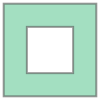

In [30]:
df_black_azov.port_buffer.iloc[0]

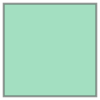

In [31]:
df_black_azov.port_coverage.iloc[0]

Plotting port coverages and buffers

In [32]:
m = folium.Map(location=[43.433333, 39.933333])

for i in range(0, 5):
    # Plot port coordinates
    folium.Marker([df_black_azov.iloc[i]['lat'], df_black_azov.iloc[i]['long']],
                  popup=df_black_azov.iloc[i]['port_name']).add_to(m)

    # Plot port coverage
    coverage = gpd.GeoSeries(df_black_azov.iloc[i]['port_coverage']).simplify(tolerance=0.001)
    geo_j = coverage.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
    
    # Plot port buffer
    buffer = gpd.GeoSeries(df_black_azov.iloc[i]['port_buffer']).simplify(tolerance=0.001)
    buffer_geo_j = buffer.to_json()
    buffer_geo_j = folium.GeoJson(data=buffer_geo_j,
                                  style_function=lambda x: {'fillColor': 'purple'})
    buffer_geo_j.add_to(m)

In [33]:
m

## Preparing data for the `get_ais` function

In [34]:
df_black_azov[['id', 'port_coverage']]

,id,port_coverage
5,44270,"POLYGON ((39.97333 43.47333, 39.97333 43.39333..."
91,43780,"POLYGON ((33.64000 44.54000, 33.64000 44.46000..."
146,43810,"POLYGON ((34.45667 44.72333, 34.45667 44.64333..."
162,43835,"POLYGON ((35.02333 44.89000, 35.02333 44.81000..."
204,43677,"POLYGON ((31.92333 46.77333, 31.92333 46.69333..."
253,43550,"POLYGON ((28.62333 43.85667, 28.62333 43.77667..."
262,43590,"POLYGON ((28.02333 45.29000, 28.02333 45.21000..."
273,44460,"POLYGON ((35.20667 42.09000, 35.20667 42.01000..."
284,43750,"POLYGON ((33.42333 45.24000, 33.42333 45.16000..."
291,43900,"POLYGON ((36.52333 45.39000, 36.52333 45.31000..."


In [36]:
ais_df.head()

,width,dt_static_utc,vessel_type_cargo,length,nav_status,dt_pos_utc,heading,cog,rot,dt_insert_utc,vessel_type_main,sog,draught,latitude,polygon_name,vessel_type,vessel_name,vessel_type_sub,H3_int_index_9,hex_resolution,longitude,mmsi,flag_country,destination,vessel_class,imo
0,47.0,2019-04-01 09:34:20,None,71.0,Not Defined,2019-04-01 10:00:59,0.0,0.0,0.0,2019-04-01 10:00:59,Offshore Vessel,0.0,0.0,45.561487,Chornomors Ke Buffer,Unknown,MODU SIVASH,None,617787929049432063,9,32.774457,273374830,Russian Federation,None,A,8763385.0
1,12.0,2019-04-01 11:50:19,None,55.0,Under Way Using Engine,2019-04-01 11:53:15,0.0,0.0,0.0,2019-04-01 11:53:15,Offshore Vessel,0.0,3.5,45.547278,Chornomors Ke Buffer,Tug,INYA,Offshore Tug Supply Ship,617787929086394367,9,32.796582,273370570,Russian Federation,YEVPATORIYA,A,8423258.0
2,12.0,2019-04-01 02:44:18,None,55.0,Under Way Using Engine,2019-04-01 02:51:42,0.0,0.0,0.0,2019-04-01 02:51:42,Offshore Vessel,0.0,3.5,45.552342,Chornomors Ke Buffer,Tug,INYA,Offshore Tug Supply Ship,617787929047334911,9,32.796950,273370570,Russian Federation,YEVPATORIYA,A,8423258.0
3,12.0,2019-04-01 22:26:17,None,55.0,Under Way Using Engine,2019-04-01 22:34:34,0.0,0.0,0.0,2019-04-01 22:34:34,Offshore Vessel,0.0,3.5,45.547288,Chornomors Ke Buffer,Tug,INYA,Offshore Tug Supply Ship,617787929086394367,9,32.796587,273370570,Russian Federation,YEVPATORIYA,A,8423258.0
4,12.0,2019-04-01 04:56:20,None,55.0,Under Way Using Engine,2019-04-01 05:01:27,0.0,0.0,0.0,2019-04-01 05:01:27,Offshore Vessel,0.0,3.5,45.552343,Chornomors Ke Buffer,Tug,INYA,Offshore Tug Supply Ship,617787929047334911,9,32.796925,273370570,Russian Federation,YEVPATORIYA,A,8423258.0


In [39]:
from geopandas import gpd 

ports = gpd.GeoDataFrame(df_black_azov[['id', 'port_coverage']]).rename(
    columns={'port_coverage': 'polygon'}
)
ports['buffer'] = 0
port_buffers = gpd.GeoDataFrame(df_black_azov[['id', 'port_buffer']]).rename(
    columns={'port_buffer': 'polygon'}
)
port_buffers['buffer'] = 1
polys = gpd.GeoDataFrame(pd.concat([ports, port_buffers], ignore_index=True),
                         geometry='polygon')

In [40]:
polys.head()

,id,polygon,buffer
0,44270,"POLYGON ((39.97333 43.47333, 39.97333 43.39333...",0
1,43780,"POLYGON ((33.64000 44.54000, 33.64000 44.46000...",0
2,43810,"POLYGON ((34.45667 44.72333, 34.45667 44.64333...",0
3,43835,"POLYGON ((35.02333 44.89000, 35.02333 44.81000...",0
4,43677,"POLYGON ((31.92333 46.77333, 31.92333 46.69333...",0


In [41]:
def filter_ports(df):
    """
    In original df there must be a latitude and longitude
    
    Returns df.
    """
    df['coordinates'] = [Point(xy) for xy in zip(df.longitude, df.latitude)] 
    points = gpd.GeoDataFrame(df, geometry='coordinates')
    points_in_polys = gpd.sjoin(points, polys, op='within')
    return points_in_polys

In [ ]:
filtered_df = filter_ports(ais_df)

/opt/mamba/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3378: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
def assign_route(df):
    """
    Returns df
    """
    raise NotImplementedError